In [29]:
from pprint import PrettyPrinter

import jax 
import jax.numpy as jnp
import jax.numpy as np ###
import numpy.random as npr ###
import jax.scipy.stats as jsps###
import jax.scipy.linalg as spla###
import jax.random as jr
import matplotlib.pyplot as plt
import optax as ox
from jax import jit
from jax.config import config
from jaxutils import Dataset
import jaxkern as jk

import gpjax as gpx

# Enable Float64 for more stable matrix inversions.
config.update("jax_enable_x64", True)
pp = PrettyPrinter(indent=4)
key = jr.PRNGKey(123)

In [299]:
nx, ny = (3, 3)
x = np.linspace(0, 1, nx)
y = np.linspace(0, 1, ny)
xv, yv = np.meshgrid(x, y)
train_x = np.array([xv.flatten(),yv.flatten()]).T

In [282]:
train_x = x[:, np.newaxis]; D=1

In [249]:
## TODO: need to learn kernel hyperparameters
#def kernel_rbf(x1, x2, params):
def kernel_rbf(x1, x2):
    """
    Squared expoential kernel with lengthscale ls. 
    """
    ls=0.1; v=1
    #ls = params["lengthscale"]; v = params["variance"]
    return v * np.exp(-0.5*np.linalg.norm(x1-x2)**2 / ls**2)

In [309]:
train_x

DeviceArray([[0. , 0. ],
             [0.5, 0. ],
             [1. , 0. ],
             [0. , 0.5],
             [0.5, 0.5],
             [1. , 0.5],
             [0. , 1. ],
             [0.5, 1. ],
             [1. , 1. ]], dtype=float64)

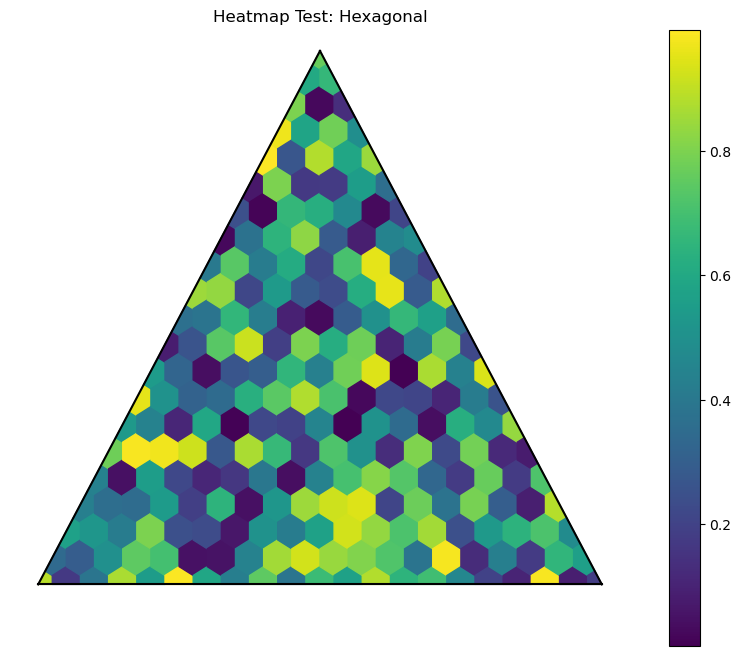

In [307]:
def generate_random_heatmap_data(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i,j,k) in simplex_iterator(scale):
        d[(i,j)] = npr.random()
    return d

scale = 20
d = generate_random_heatmap_data(scale)
figure, tax = ternary.figure(scale=scale)
figure.set_size_inches(10, 8)
tax.heatmap(d, style="h")
tax.boundary()
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax.set_title("Heatmap Test: Hexagonal")

In [308]:
d

{(0, 0): 0.8895200639461449,
 (0, 1): 0.34161365267110966,
 (0, 2): 0.5671441276277093,
 (0, 3): 0.42754596329611005,
 (0, 4): 0.436747263026799,
 (0, 5): 0.7765591849971003,
 (0, 6): 0.5356041734976563,
 (0, 7): 0.9537422269448667,
 (0, 8): 0.5442081601481021,
 (0, 9): 0.0820949222750248,
 (0, 10): 0.3663424016750204,
 (0, 11): 0.8508505040045017,
 (0, 12): 0.4062750430479508,
 (0, 13): 0.02720236589484959,
 (0, 14): 0.24717723899735333,
 (0, 15): 0.06714437073695467,
 (0, 16): 0.9938520114212729,
 (0, 17): 0.9705803133771735,
 (0, 18): 0.8002583511325868,
 (0, 19): 0.6018171214054674,
 (0, 20): 0.7649598604516815,
 (1, 0): 0.16922544658417793,
 (1, 1): 0.2930232318194398,
 (1, 2): 0.5240668753003642,
 (1, 3): 0.3566242811227589,
 (1, 4): 0.04567896524540005,
 (1, 5): 0.9831534453572127,
 (1, 6): 0.4413549193548467,
 (1, 7): 0.5040004393791526,
 (1, 8): 0.32354131753469884,
 (1, 9): 0.25974475274713704,
 (1, 10): 0.3868898853207624,
 (1, 11): 0.8320168996345009,
 (1, 12): 0.7367470562

In [252]:
def K(kernel, xs, ys):
  """Compute a Gram matrix or vector from a kernel and an array of data points.
  Args:
    kernel: callable, maps pairs of data points to scalars.
    xs: array of data points, stacked along the leading dimension.
  Returns:
    A 2d array `a` such that `a[i, j] = kernel(xs[i], xs[j])`.
  """
  return jax.vmap(lambda x: jax.vmap(lambda y: kernel(x, y))(ys))(xs)

In [279]:
K(kernel_rbf, train_x, test_x).T.shape

(1, 3)

In [292]:

#train_K = kernel(train_x, train_x, params) + 1e-6*np.eye(train_x.shape[0])
#cross_K = kernel(train_x, test_x, params)
#kappa_K = kernel(test_x, test_x, params)


train_K = K(kernel_rbf, train_x, train_x) + 1e-6*np.eye(train_x.shape[0])
cross_K = K(kernel_rbf, train_x, test_x)
kappa_K = K(kernel_rbf, test_x, test_x)

# Predictive parameters.
train_cK = spla.cholesky(train_K)
cross_solve = spla.cho_solve((train_cK,  False), cross_K)
#pred_mean = train_y.T @ cross_solve
pred_cov  = kappa_K - cross_K.T @ cross_solve  + 1e-6*np.eye(train_x.shape[1])


In [294]:
train_K.shape

(9, 9)

In [183]:
test_x = np.ones((1,2)) * 0.65

In [209]:
test_x.shape

(1, 2)

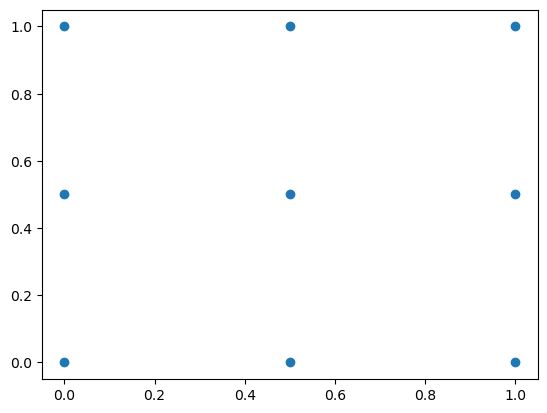

In [298]:
plt.scatter(x_train[:,0], x_train[:,1])

In [289]:
train_x.shape[1]

1

In [112]:
params = learned_params["kernel"]

In [290]:
## TODO: need to learn kernel hyperparameters
def kernel(x1, x2, params):
    """
    Squared expoential kernel with lengthscale ls. 
    """
    ls = params["lengthscale"]; v = params["variance"]
    
    x1 = np.atleast_2d(x1)
    x2 = np.atleast_2d(x2)
    return v * np.exp(-0.5*(x1.T-x2)**2 / ls**2)


def make_preds(train_x, train_y, test_x, params):
    """
    Given data, get pred_mean and pred_cov. 
    """
    # Compute the training kernels.
    train_K = K(train_x, train_x, params) + 1e-6*np.eye(train_x.shape[0])
    cross_K = K(train_x, test_x, params)
    kappa_K = K(test_x, test_x, params)

    # Predictive parameters.
    train_cK = spla.cholesky(train_K)
    cross_solve = spla.cho_solve((train_cK,  False), cross_K)
    pred_mean = train_y.T @ cross_solve
    pred_cov  = kappa_K - cross_K.T @ cross_solve + 1e-6*np.eye(train_x.shape[1])

    return pred_mean, pred_cov


# Compute the convex envelope given x and y values
def convelope(knot_x, knot_y):
    # todo kernel fn
    d_kernel = jax.jit(jax.vmap(jax.grad(jax.grad(lambda x1, x2, params: kernel(x1, x2, params)[0,0], argnums=0), argnums=1), in_axes=(0,0,None)))

    # TODO: 
    deriv_marg_var = np.max(np.diag(d_kernel(knot_x, knot_x, params)))
    s = np.linspace(-3*np.sqrt(deriv_marg_var), 3*np.sqrt(deriv_marg_var), 500)

    knot_y = np.atleast_2d(knot_y) # samples x num_primal
    sx = s[:,np.newaxis] * knot_x[np.newaxis,:] # num_dual x num_primal
    # compute the conjugate
    lft1 = np.max(sx[np.newaxis,:,:] - knot_y[:,np.newaxis,:],  axis=2) # samples x num_dual
    # compute the biconjugate
    lft2 = np.max(sx[np.newaxis,:,:] - lft1[:,:,np.newaxis],  axis=1) # samples x num_primal
    return lft2


def generate_true_function(knot_N, kernel, params):
    knot_x = np.linspace(0, 1, knot_N)
    knot_K = kernel(knot_x, knot_x, params) + 1e-8 * np.eye(knot_N)
    # Cholesky decomposition of the kernel matrix
    knot_cK = spla.cholesky(knot_K)
    # Form the true function of interest at knot_N number of points
    true_y = knot_cK.T @ npr.randn(knot_N)
    # compute envelope based on true function
    true_envelope = convelope(knot_x, true_y)
    
    return true_y, true_envelope

# Number of points to discretize the space into
knot_N = 40
# grid to discretize design space into
knot_x = np.linspace(0, 1, knot_N)

# Set random seed
npr.seed(2)
# Length scale for the kernel
ls = 0.8
true_y, true_envelope = generate_true_function(knot_N, kernel, params)

In [87]:
n = knot_N
xx = knot_x[np.newaxis].reshape(-1, 1)
yy = true_y.reshape(-1,1)

In [94]:
"""
n = 100
noise = 0.

x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal #+ jr.normal(key, shape=signal.shape) * noise

D = Dataset(X=x, y=y)


#xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
#ytest = f(xtest)
""";

In [95]:
DD = Dataset(X=xx, y=yy)

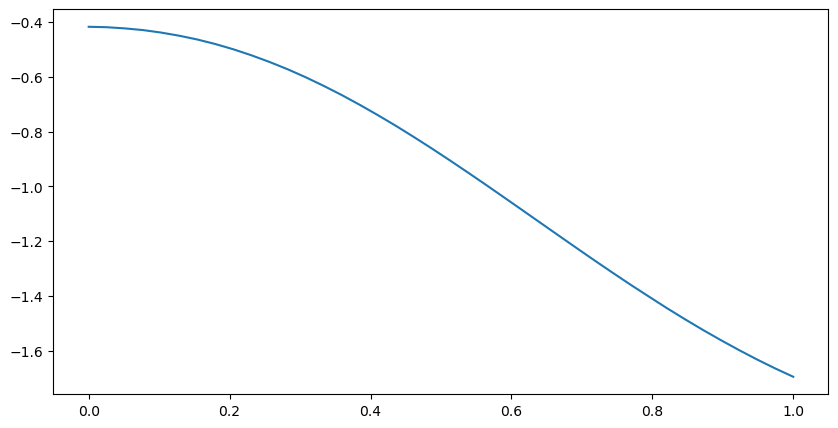

In [96]:
fig, ax = plt.subplots(figsize=(10, 5))
#ax.plot(xtest, ytest, label="Latent function")
ax.plot(xx, yy,  label="Observations")
#ax.legend(loc="best")

In [97]:
def get_parameters(xx, yy):
    DD = Dataset(X=xx, y=yy)
    kernel = jk.RBF()
    prior = gpx.Prior(kernel=kernel)
    likelihood = gpx.Gaussian(num_datapoints=DD.n)
    posterior = prior * likelihood
    
    parameter_state = gpx.initialise(
        posterior, key, kernel={"lengthscale": jnp.array([0.5])} # initial ls
    )
    
    params, trainable, bijectors = parameter_state.unpack()
    
    negative_mll = jit(posterior.marginal_log_likelihood(DD, negative=True))
    negative_mll(params)
    optimiser = ox.adam(learning_rate=0.01)

    inference_state = gpx.fit(
        objective=negative_mll,
        parameter_state=parameter_state,
        optax_optim=optimiser,
        num_iters=500,
    )
    learned_params, training_history = inference_state.unpack()

    ls = learned_params['kernel']['lengthscale'][0]
    v = learned_params['kernel']['variance'][0]
    
    return ls, v

In [92]:
get_parameters(xx, yy)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 838.83it/s, Objective=-48.09]


(DeviceArray(0.84348756, dtype=float64),
 DeviceArray(1.43066951, dtype=float64))

In [98]:
kernel(knot_x, knot_x, ls)

DeviceArray([[1.        , 0.99948649, 0.99794754, ..., 0.49501047,
              0.47630373, 0.45783336],
             [0.99948649, 1.        , 0.99948649, ..., 0.5139237 ,
              0.49501047, 0.47630373],
             [0.99794754, 0.99948649, 1.        , ..., 0.53301172,
              0.5139237 , 0.49501047],
             ...,
             [0.49501047, 0.5139237 , 0.53301172, ..., 1.        ,
              0.99948649, 0.99794754],
             [0.47630373, 0.49501047, 0.5139237 , ..., 0.99948649,
              1.        , 0.99948649],
             [0.45783336, 0.47630373, 0.49501047, ..., 0.99794754,
              0.99948649, 1.        ]], dtype=float64)

In [99]:
kernel = jk.RBF()

In [107]:
kernel(learned_params['kernel'], np.ones(1), np.ones(1))

DeviceArray(0.77245987, dtype=float64)

In [106]:
?kernel

In [63]:
likelihood = gpx.Gaussian(num_datapoints=DD.n)
posterior = prior * likelihood
parameter_state = gpx.initialise(
    posterior, key, kernel={"lengthscale": jnp.array([0.5])} # initial ls
)

In [64]:
params, trainable, bijectors = parameter_state.unpack()
pp.pprint(params)

{   'kernel': {   'lengthscale': DeviceArray([0.5], dtype=float64),
                  'variance': DeviceArray([1.], dtype=float64)},
    'likelihood': {'obs_noise': DeviceArray([1.], dtype=float64)},
    'mean_function': {}}


In [67]:
negative_mll = jit(posterior.marginal_log_likelihood(DD, negative=True))
negative_mll(params)
optimiser = ox.adam(learning_rate=0.01)

inference_state = gpx.fit(
    objective=negative_mll,
    parameter_state=parameter_state,
    optax_optim=optimiser,
    num_iters=500,
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1006.39it/s, Objective=-24.04]


In [68]:
learned_params, training_history = inference_state.unpack()

pp.pprint(learned_params)

{   'kernel': {   'lengthscale': DeviceArray([0.11260763], dtype=float64),
                  'variance': DeviceArray([0.77245987], dtype=float64)},
    'likelihood': {'obs_noise': DeviceArray([0.00733905], dtype=float64)},
    'mean_function': {}}


In [296]:
#latent_dist = posterior(learned_params, D)(xtest)
## THIS LINE DOESN'T WORK FOR ME
#predictive_dist = likelihood(learned_params, latent_dist) #
#predictive_mean = predictive_dist.mean()
#predictive_std = predictive_dist.stddev()